# CSCE 823 Homework 2 Example Solution

Original Author: Lt Garrett Alarcon - (CSCE 823, 2019)


In [1]:
import os
import numpy as np
import pandas as pd
import copy
#import keras as keras
import tensorflow as tf
from tensorflow import keras as keras
import matplotlib.pyplot as plt
import random

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import metrics
from matplotlib import pyplot
from matplotlib import cm

RUN_CONFIGURATION_LOOP = True

In [2]:
print("Tensorflow version: ", tf.__version__)
print("Tensorflow devices: ", tf.config.list_physical_devices("GPU"))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

Tensorflow version:  2.6.0
Tensorflow devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Step 1. Import Data

In [4]:
TrainingSet = pd.read_csv('CSCE823_HW2_regression_non_testdata.csv')
TestSet = pd.read_csv('CSCE823_HW2_regression_testdata.csv')
TrainingSet = TrainingSet.values
TestSet = TestSet.values
np.random.shuffle(TrainingSet)
np.random.shuffle(TestSet)
X_train = TrainingSet[:,0:2]
y_train = TrainingSet[:,2]
X_test = TestSet[:,0:2]
y_test = TestSet[:,2]

### Step 2a. Build Function for Z Calculation

In [5]:
def computeZ(x1,x2):
    
    z = x1**2-x2**2
    
    return z

### Step 2b. Build Function for 3D Surface Plot

In [6]:
def build3DSurface(Xdata, ydata):
    x = Xdata[:,0]
    y = Xdata[:,1]
    z = computeZ(x,y)
    zdata = ydata
    
    fig = plt.figure(figsize = (8,8))
    # ax = fig.gca(projection='3d')
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)
    ax.scatter3D(x, y, zdata, c=zdata, cmap='Greens')
    plt.title('Raw Errors on Saddle Surface')
    plt.ylabel('x2')
    plt.xlabel('x1')

### Step 2c. Explore Data with 2D and 3D Plots

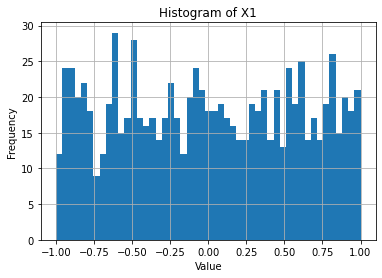

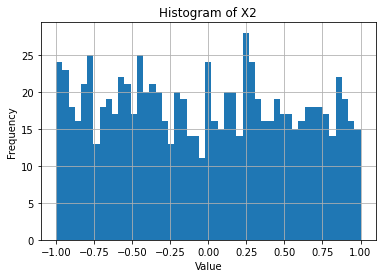

In [7]:
plt.figure(1)
bins = np.linspace(-1,1,50)
plt.hist(X_train[:,0],bins)
plt.title('Histogram of X1')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.grid(True)

plt.figure(2)
plt.hist(X_train[:,1],bins)
plt.title('Histogram of X2')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.grid(True)

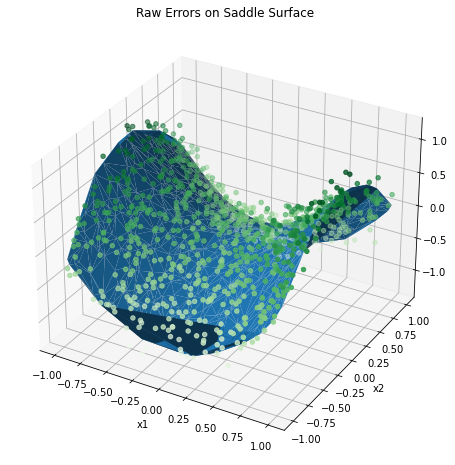

In [8]:
build3DSurface(X_train, y_train)
plt.show()

### Step 2d. Determine Raw Error

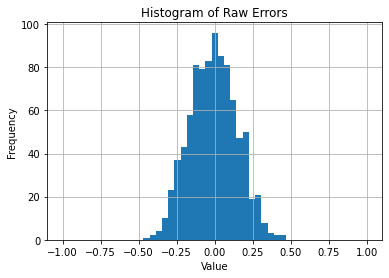

In [9]:
errors = np.zeros(len(X_train))
errors = computeZ(X_train[:,0], X_train[:,1]) - y_train

plt.figure(3)
plt.hist(errors, bins)
plt.title('Histogram of Raw Errors')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.grid(True)

The histogram of the raw errors resembles a normal distribution. It doesn't look particulary skewed in any direction, and fairly centered around 0. The noise in the data resembles random gaussian noise. It shouldn't affect the model that much, but it will depend on the configuration of the network and the activation functions used. There doesn't look to be any extreme outliers.

### Step 2e. Scatterplot of True Saddle Values vs Raw Errors

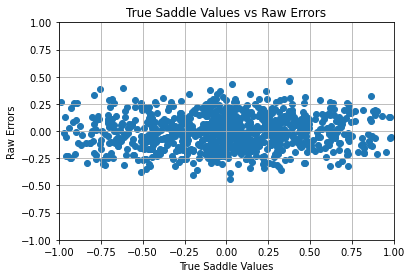

In [10]:
plt.figure(3)
plt.scatter(computeZ(X_train[:,0], X_train[:,1]), errors)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title('True Saddle Values vs Raw Errors')
plt.xlabel('True Saddle Values')
plt.ylabel('Raw Errors')
plt.grid(True)

The errors in the scatterplot closely mirror that which was shown in the histogram. They are closely centered around 0 with a horizontal linear feel. They could be argued to resemble residuals that are uniformly spread, but they are a little too centered between -0.5 - 0.5.

### Step 2f. Report Metrics on Error

In [11]:
mse = np.dot(errors, errors.T)/len(errors)
rmse = np.sqrt(mse)
mae = np.sum(np.absolute(errors))/len(errors)
print("The MSE = " + str(mse))
print("The RMSE = " + str(rmse))
print("The MAE = " + str(mae))

The MSE = 0.02363522500631579
The RMSE = 0.15373751983922399
The MAE = 0.12465195801133512


### Step 3. Prepare Data for Training/Validation

In [12]:
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, train_size = 0.75, random_state=1)

### Step 4. Build Function to Return Compiled Keras Model

In [13]:
def ANNmodel(layers, nodes, learningRate, activationFunc, opt):
    
    model = Sequential()
    model.add(Dense(nodes, input_dim = 2)) # Input Layer
    
    for i in range(0,layers): # Create hidden layers
        model.add(Dense(nodes, activation = activationFunc))
        
    model.add(Dense(1, activation = 'tanh')) # Output layer

    engine = opt(learning_rate=learningRate)
    model.compile(optimizer=engine, loss='mean_squared_error', metrics=[metrics.mse, metrics.mae])
    
    return model

### Step 5. Define Model Configurations

In [14]:
nodes = np.array([5,10])
layers = np.array([1,2])
lrnRate = np.array([0.09])
actFunc = np.array(['tanh', 'sigmoid'])
optimizer = np.array([optimizers.Adam, optimizers.SGD])

### Step 6a. Train Configurations

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])

Parameters: 1 layers, 5 nodes per layer, 0.09 learning rate, tanh activation function, <class 'keras.optimizer_v2.adam.Adam'> optimizer


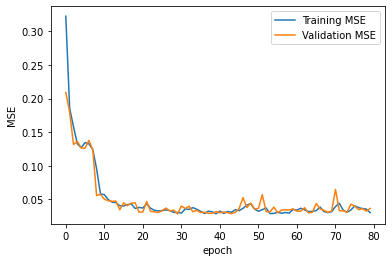

Min Val MSE = 0.028093189001083374 at epoch 29

newbest:  [0, 0, 0, 0, 0]
Parameters: 1 layers, 5 nodes per layer, 0.09 learning rate, tanh activation function, <class 'keras.optimizer_v2.gradient_descent.SGD'> optimizer


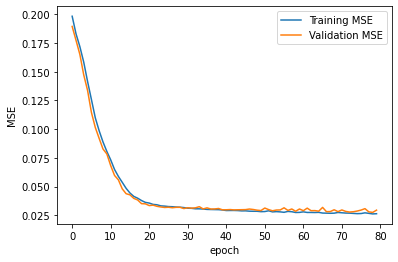

Min Val MSE = 0.02746853046119213 at epoch 78

newbest:  [0, 0, 0, 0, 1]
Parameters: 1 layers, 5 nodes per layer, 0.09 learning rate, sigmoid activation function, <class 'keras.optimizer_v2.adam.Adam'> optimizer


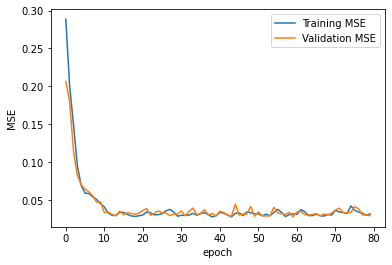

Min Val MSE = 0.027872860431671143 at epoch 59

Parameters: 1 layers, 5 nodes per layer, 0.09 learning rate, sigmoid activation function, <class 'keras.optimizer_v2.gradient_descent.SGD'> optimizer


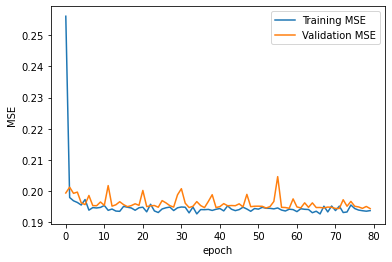

Min Val MSE = 0.19429485499858856 at epoch 79

Parameters: 1 layers, 10 nodes per layer, 0.09 learning rate, tanh activation function, <class 'keras.optimizer_v2.adam.Adam'> optimizer


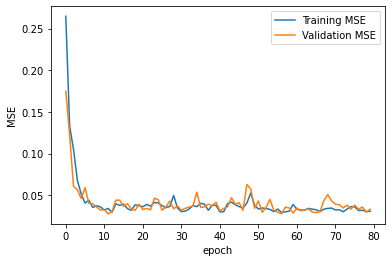

Min Val MSE = 0.027510441839694977 at epoch 11

Parameters: 1 layers, 10 nodes per layer, 0.09 learning rate, tanh activation function, <class 'keras.optimizer_v2.gradient_descent.SGD'> optimizer


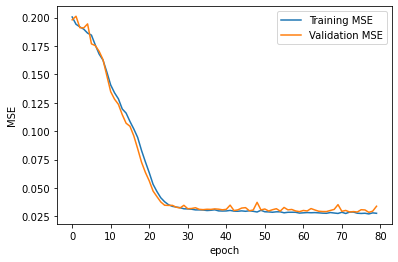

Min Val MSE = 0.02863321453332901 at epoch 77

Parameters: 1 layers, 10 nodes per layer, 0.09 learning rate, sigmoid activation function, <class 'keras.optimizer_v2.adam.Adam'> optimizer


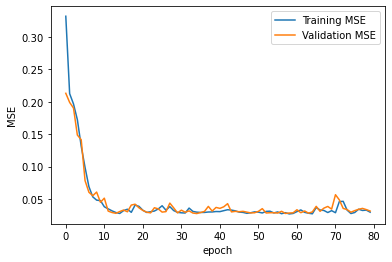

Min Val MSE = 0.02758670039474964 at epoch 34

Parameters: 1 layers, 10 nodes per layer, 0.09 learning rate, sigmoid activation function, <class 'keras.optimizer_v2.gradient_descent.SGD'> optimizer


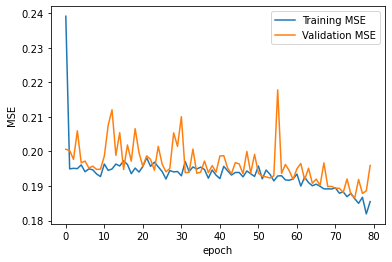

Min Val MSE = 0.18657730519771576 at epoch 75

Parameters: 2 layers, 5 nodes per layer, 0.09 learning rate, tanh activation function, <class 'keras.optimizer_v2.adam.Adam'> optimizer


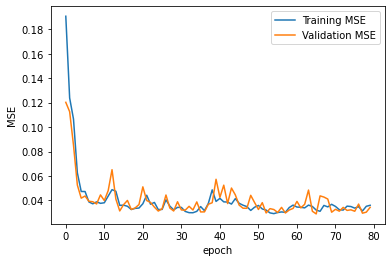

Min Val MSE = 0.028957592323422432 at epoch 65

Parameters: 2 layers, 5 nodes per layer, 0.09 learning rate, tanh activation function, <class 'keras.optimizer_v2.gradient_descent.SGD'> optimizer


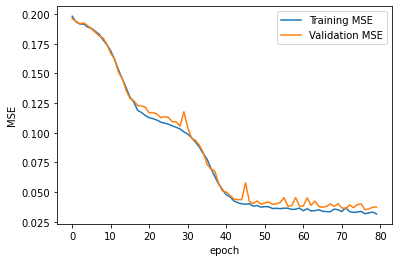

Min Val MSE = 0.035239167511463165 at epoch 76

Parameters: 2 layers, 5 nodes per layer, 0.09 learning rate, sigmoid activation function, <class 'keras.optimizer_v2.adam.Adam'> optimizer


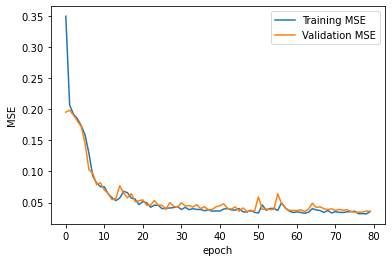

Min Val MSE = 0.03447030857205391 at epoch 75

Parameters: 2 layers, 5 nodes per layer, 0.09 learning rate, sigmoid activation function, <class 'keras.optimizer_v2.gradient_descent.SGD'> optimizer


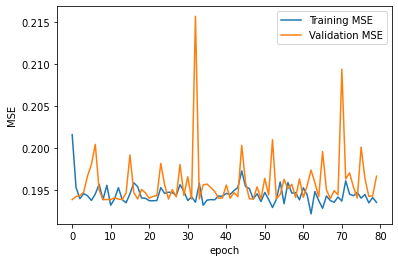

Min Val MSE = 0.1938253492116928 at epoch 0

Parameters: 2 layers, 10 nodes per layer, 0.09 learning rate, tanh activation function, <class 'keras.optimizer_v2.adam.Adam'> optimizer


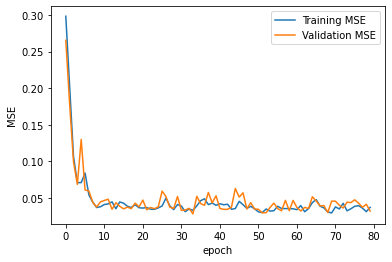

Min Val MSE = 0.027941415086388588 at epoch 33

Parameters: 2 layers, 10 nodes per layer, 0.09 learning rate, tanh activation function, <class 'keras.optimizer_v2.gradient_descent.SGD'> optimizer


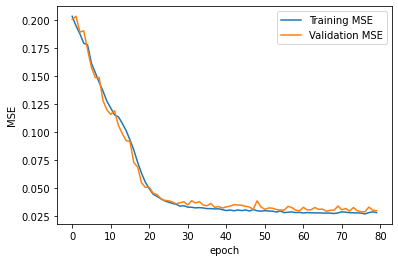

Min Val MSE = 0.028965625911951065 at epoch 76

Parameters: 2 layers, 10 nodes per layer, 0.09 learning rate, sigmoid activation function, <class 'keras.optimizer_v2.adam.Adam'> optimizer


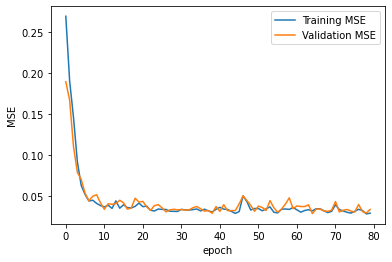

Min Val MSE = 0.028519172221422195 at epoch 64

Parameters: 2 layers, 10 nodes per layer, 0.09 learning rate, sigmoid activation function, <class 'keras.optimizer_v2.gradient_descent.SGD'> optimizer


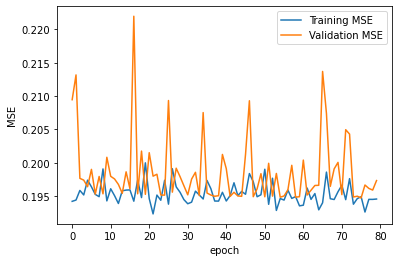

Min Val MSE = 0.19475361704826355 at epoch 75

BEST MODEL
Parameters: 1 layers, 5 nodes per layer, 0.09 learning rate, tanh activation function, <class 'keras.optimizer_v2.gradient_descent.SGD'> optimizer
Epoch:  78
Min Val MSE =  0.02746853046119213


In [15]:
if RUN_CONFIGURATION_LOOP == True:
     
    h = 0
    
    bestVal = 10e+10
    bestConfig = None
    bestEpoch = 0

    for i in range(len(layers)):
        for j in range(len(nodes)):
            for k in range(len(lrnRate)):
                for n in range(len(actFunc)):
                    for m in range(len(optimizer)):

                       #print(history.history.keys())
                        curConfig = [i,j,k,n,m]
                        
                        print('Parameters: '+str(layers[i])+' layers, '
                              +str(nodes[j])+' nodes per layer, '
                              +str(lrnRate[k])+' learning rate, '
                              +str(actFunc[n])+' activation function, '
                              +str(optimizer[m])+ ' optimizer')
                        model = ANNmodel(layers=layers[i], nodes=nodes[j], learningRate=lrnRate[k], activationFunc=actFunc[n], opt=optimizer[m])
                        history = model.fit(X_trn, y_trn, validation_data=(X_val,y_val), epochs=80, batch_size=50, verbose = 0, callbacks = None)
 
                        plt.figure(h)
                        plt.plot(history.history['mean_squared_error'])
                        plt.plot(history.history['val_mean_squared_error'])
                        plt.legend(['Training MSE','Validation MSE'])
                        plt.xlabel("epoch")
                        plt.ylabel("MSE")

                        plt.show()
                        
                        minValMSE = np.min(history.history['val_mean_squared_error'])
                        minValepoch =np.argmin(history.history['val_mean_squared_error'])
                        #print("Min Val MSE = " + str(history.history['mean_squared_error'][-1]))
                        print("Min Val MSE = " + str(minValMSE) +" at epoch "+ str(minValepoch))
                        print("")
                        if minValMSE < bestVal:
                            print("newbest: ",curConfig)
                            bestVal=minValMSE
                            bestConfig = curConfig
                            bestEpoch = minValepoch

                        h = h+1
    print("BEST MODEL")
    
    print('Parameters: '+str(layers[bestConfig[0]])+' layers, '
      +str(nodes[bestConfig[1]])+' nodes per layer, '
      +str(lrnRate[bestConfig[2]])+' learning rate, '
      +str(actFunc[bestConfig[3]])+' activation function, '
      +str(optimizer[bestConfig[4]])+ ' optimizer')
    print("Epoch: ", bestEpoch)
    print("Min Val MSE = ", bestVal)


### Step 6b. Report Best Configuration

The best configuration is:

- Nodes: 10
- Hidden Layers: 1
- Learning Rate: 0.09
- Activation Function: Tanh
- Optimizer: SGD

I believe this configuration worked the best because of the optimizer, learning rate, and activation function. In examining the other choices, a sigmoid activation function in the hidden layer, along with the SGD optimizer produced poor results. Sigmoid with adam did better, but only when the learninig rate was lower. It also performed better with one layer instead of two. Overall the tanh function performed the best for multiple configurations. The SGD optimizer worked best with the tanh activation function, and with the lower learning rate. When the extra layer was added, the model still performed but not as well. Therefore the combination of the lower learning rate paired with the tanh activation function and SGD optimizer performed the best. The number of nodes didn't seem to have a large impact on performance. It might have to be increased or decreased more in order to explore that relationship.

### Step 7. Select Best Configuration

In [16]:
model = ANNmodel(1, 10, 0.09, 'tanh', optimizers.SGD)

### Step 8. Retrain Model

In [17]:
history = model.fit(X_train, y_train, epochs=80, batch_size=50, verbose = 0, callbacks = None)
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error'])


In [18]:
history = model.fit(X_trn, y_trn, validation_data=(X_val,y_val), epochs=80, batch_size=50, verbose = 0, callbacks = None)
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


### Step 9a. Run Predictions on Non-Test Data

In [19]:
y = model.predict(X_train, batch_size = 50)

### Step 9b. Determine Prediction Errors and Create Histogram

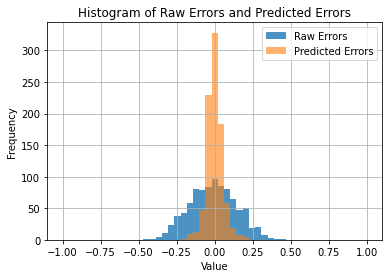

In [20]:
yTrue = computeZ(X_train[:,0], X_train[:,1])
NewError = yTrue - y[:,0]

plt.hist(errors, bins, alpha = 0.8, label = 'Raw Errors')
plt.hist(NewError, bins, alpha = 0.6, label = 'Predicted Errors')
plt.title('Histogram of Raw Errors and Predicted Errors')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.legend()
plt.grid(True)

The predicted errors are much better than the raw errors from the noise. Majority of the values are centered around 0. The model seems to have been able to de-noise the dataset.

### Step 9c. Scatterplot of True Values vs Prediction Errors

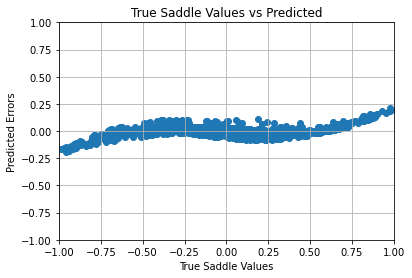

In [21]:
plt.scatter(computeZ(X_train[:,0], X_train[:,1]), NewError)
plt.title('True Saddle Values vs Predicted')
plt.xlabel('True Saddle Values')
plt.ylabel('Predicted Errors')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid(True)

The errors are much tighter and closer to 0 than the raw errors from the noise. But there is now a pattern in the residuals which is indicative of the non-linear nature of the saddle function. We can also see that the model performed worse with saddle values that closer to -1 and 1, as we reached the outer bounds of the saddle.

### Step 9d. Report Metrics

In [22]:
mse = np.dot(NewError, NewError.T)/len(NewError)
rmse = np.sqrt(mse)
mae = np.sum(np.absolute(NewError))/len(NewError)
print("The MSE = " + str(mse))
print("The RMSE = " + str(rmse))
print("The MAE = " + str(mae))

The MSE = 0.0026477630506164815
The RMSE = 0.051456418944738874
The MAE = 0.037587377295433363


The predicted error rates beat the same performance measures on raw errors caused by data noise by a significant amount. This leads more credence that the model is performing as shown above, and removing the noise from the original dataset.

### 10. Evaluate Model on Test Set

In [23]:
scores = model.evaluate(X_test, y_test, batch_size = 50)
print(scores)
y = model.predict(X_test, batch_size = 50)

50/50 [==============================] - 0s 3ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0390
[0.002823773305863142, 0.002823773305863142, 0.03898337110877037]


### Step 10a. Create 3D Plot of Values

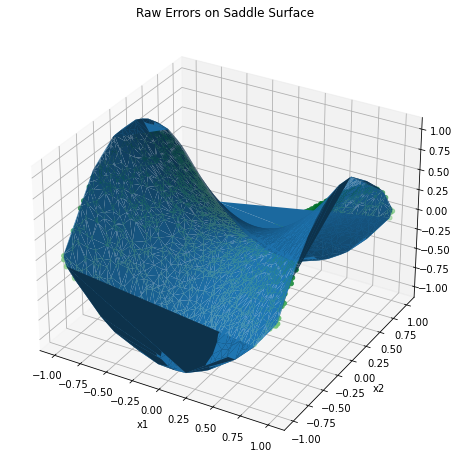

In [24]:
build3DSurface(X_test, y[:,0])
plt.show()

As suggested by the scatterplot and histogram of the predicted errors, the model performed excellent in all areas except near the boundaries of -1 and 1 for x1 and x2

### Step 10b. Histogram of Prediction Errors

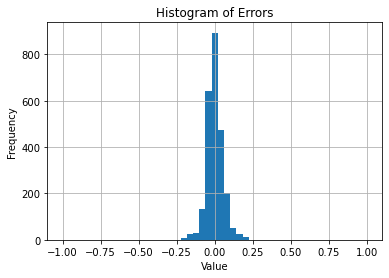

In [25]:
yTrue = computeZ(X_test[:,0], X_test[:,1])
TestError = np.zeros(len(X_test))
TestError = yTrue - y[:,0]

plt.hist(TestError, bins)
plt.title('Histogram of Errors')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.grid(True)

### Step 10c. Scatterplot of Prediction Errors

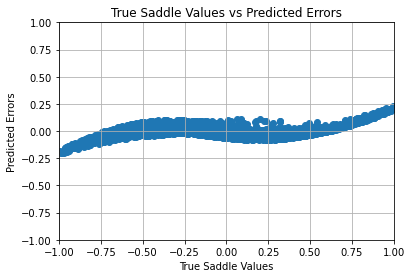

In [26]:
plt.scatter(yTrue, TestError)
plt.title('True Saddle Values vs Predicted Errors')
plt.xlabel('True Saddle Values')
plt.ylabel('Predicted Errors')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid(True)

Looks very similiar to the scatterplot for the training set in step 9. The model performs well even on the test set indicating its ability to generalize. It still has the same issues around saddle values of -1 and 1.

In [27]:
mse = np.dot(TestError, TestError.T)/len(TestError)
rmse = np.sqrt(mse)
mae = np.sum(np.absolute(TestError))/len(TestError)
print("The MSE = " + str(mse))
print("The RMSE = " + str(rmse))
print("The MAE = " + str(mae))

The MSE = 0.00282377340550031
The RMSE = 0.05313918898045312
The MAE = 0.03898337614847003


While the performance metrics are slightly higher than the training set, this is expected. Since test set performance will always be close to the same or worse than traininig set performance. But like the training set, the model with the test set performed leagues better than the set with just the raw noise. Again, showing its ability to remove noise from the data set.

The numbers above are also confirmed with the model's evaluate function, which produced the same metrics.